In [26]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [27]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [42]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
#using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [29]:
#using Pkg
#Pkg.add("ProgressMeter");

In [30]:
@load "../data/sim3data.jld";

In [31]:
# priors #
p = size(X_ord)[2]; q = size(Y_ord)[2]; K = 1;
μβ = spzeros(p, q); inv_Vr = spzeros(p, p);
μΛ = spzeros(K, q); inv_VΛ = spzeros(K, K)
aΣ = 2; bΣ = fill(1.0, q);
inv_Lr = spzeros(p, p); inv_LΛ = spzeros(K, K);
aϕ = fill(2.0, K); bϕ = fill(33 / (2 * sqrt(2)), K);

In [32]:
# Some data preparations #

m = 10; n = length(S); 
# number of nearest neighbor                       
NN = BuildNN(coords_ord[S, :], m);                            # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

dim_invD = sum(index_S_M);
invD_yind = 1:dim_invD; invD_xind = 1:dim_invD;
Xtilde_indy_up = vcat([S .+ (ind - 1) * N for ind in 1:K]...);
nsam = length(perm_ind) + (K * n);

In [33]:
# preallocation #
μ_m = [Array{Float64, 2}(undef, length(M_ind[i]), q) for i in 1:q];
nIndx = length(NN.nnIndx);
A = [Array{Float64}(undef, nIndx) for i in 1:K];
D = [Array{Float64}(undef, n) for i in 1:K];
I_A = [spzeros(n, n) for i in 1:K];
A_new = [Array{Float64}(undef, nIndx) for i in 1:K];
D_new = [Array{Float64}(undef, n) for i in 1:K];
I_A_new = [spzeros(n, n) for i in 1:K];
Ystar = vcat(Y_ord[S, :], inv_Lr * μβ, inv_LΛ * μΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] spzeros(n, K)], [inv_Lr spzeros(p, K)], 
    [spzeros(K, p) inv_LΛ]);      
bstar = fill(0.0, q); astar = aΣ + 0.5 * n;
μγstar = vcat(μβ, μΛ); invVγstar = fill(0.0, p + K, p + K);
Y_Xm = spzeros(n + p + K, q);
nsam = length(perm_ind) + (K * n);
Ytilde =  Array{Float64}(undef, nsam);
Xtilde = SparseMatrixCSC{Float64,Int64};
#precond_D = Array{Float64, 1}(undef, K * n);
lll = fill(1.0, (n, 1)); 

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [72]:
# Preallocation for MCMC samples and Initalization #
N_sam = 10000;
N_pre_burn = Integer(trunc(0.75 * N_sam));
N_pre_adapt = Integer(trunc(0.25 * N_sam));
N_after_burn = N_sam - N_pre_burn;
ω_incp_sam = Array{Float32, 2}(undef, n, q);

ω_incp_sam_mean = fill(0.0, n, q);
ω_incp_sam_var = fill(0.0, n, q);
Y_m_sam_mean = [fill(0.0, length(M_ind[i])) for i in 1:length(M_ind)];
Y_m_sam_var = [fill(0.0, length(M_ind[i])) for i in 1:length(M_ind)];

F_sam = Array{Float64, 2}(undef, n, K);
Y_m_sam =  [Array{Float64, 1}(undef, length(M_ind[i])) for i in 1:q];
A_sam = Array{Float64, 2}(undef, N_sam, K); # acceptance rate
lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges

ϕ_sam = Array{Float64, 2}(undef, K, N_sam + 1);

γ_sam = vcat(fill(0.0, p, q), fill(0.001, K, q));
γ_sam[(p + 1):(p + K), 1:K] = γ_sam[(p + 1):(p + K), 1:K] + I;
Σ_sam = fill(0.2, q);
ω_cov_sam = fill(0.0, q, q);
ϕ_sam[:, 1] = fill(6.0, K);

#precond_D = Array{Float64, 1}(undef, K * n);
inv_sqrt_Σ_diag = Array{Float64, 1}(undef, q);
RWM_scale = fill(0.1, K);

In [73]:
using DelimitedFiles
writedlm("../results/K1/γ_sam.csv", vcat(fill(0.0, 1, q), γ_sam), ", ");
writedlm("../results/K1/Σ_sam.csv", vcat(0.0, Σ_sam), ", ");
writedlm("../results/K1/ω_cov_sam.csv", [fill(0.0, q)], ", ");
writedlm("../results/K1/ϕ_sam.csv", vcat(0.0, ϕ_sam[:, 1]), ", ");
writedlm("../results/K1/A_sam.csv", 0.0, ", ");

In [74]:
# for loop for MCMC chain #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    inv_sqrt_Σ_diag = 1 ./ (sqrt.(Σ_sam));
    invD_ele = [x for ind in 1:q for x in fill(inv_sqrt_Σ_diag[ind], length(S_ind[ind]))];
    invD = sparse(invD_xind, invD_yind, invD_ele);
                
    if l == 1
        for k in 1:K
            getAD(coords_ord[S, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[k, l], 0.5, 
                            A[k], D[k]);
            I_A[k] = sparse(nnIndx_row, nnIndx_col, vcat(-A[k], ones(n)));
        end
    end
    Ytilde = vcat(invD * vcat([Y_ord[S_ind[ind], ind] - X_ord[S_ind[ind], :] * 
                            γ_sam[1:p, ind] for ind in 1:q]...), zeros(K * n));
    Xtilde = vcat(invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, Xtilde_indy_up],
             blockdiag([Diagonal(1 ./ sqrt.(D[ind])) * I_A[ind] for ind in 1:K]...));
                  
    # use LSMR to generate sample of F #       
    #Precond_D = colnorm(Xtilde);             
    #F_sam = reshape(Diagonal(1 ./ Precond_D) * lsmr(Xtilde * Diagonal(1 ./ Precond_D), 
    #                     collect(Ytilde) + rand(Normal(), nsam)), :, K);                
    F_sam = reshape(lsmr(Xtilde, collect(Ytilde) + rand(Normal(), nsam)), :, K);
                
    # impute missing response  over S#
    Xstar[1:n, (p + 1):(p + K)] = F_sam;        # update matrix Xstar with F
    if(l > N_pre_burn) # only save ω_incp_sam after burn-in
        ω_incp_sam = F_sam * γ_sam[(p + 1):(p + K), :] + lll * transpose(γ_sam[1, :]); 
        ω_incp_sam_mean = ω_incp_sam_mean + (ω_incp_sam ./ N_after_burn);
        ω_incp_sam_var = ω_incp_sam_var + ((ω_incp_sam.^2) ./ N_after_burn);  
        ω_cov_sam = cov(ω_incp_sam);
    else
        ω_cov_sam = cov(F_sam * γ_sam[(p + 1):(p + K), :]);
    end                    
    io1 = open("../results/K1/ω_cov_sam.csv", "a" ); # covariance of latent process
    writedlm(io1, ω_cov_sam, ", ");
    close(io1);            
           
    # impute missing response  over S#            
    for ind in 1:q
        Y_m_sam[ind] = Xstar[M_Sind[ind], :] * γ_sam[:, ind]+   
            rand(Normal(0.0, sqrt(Σ_sam[ind])), length(M_ind[ind]));
    end
         
    if (l > N_pre_burn)  # only save imputed Y after burn-in
        for ind in 1:q
            Y_m_sam_mean[ind] = Y_m_sam_mean[ind] + (Y_m_sam[ind] ./ N_after_burn);
            Y_m_sam_var[ind] = Y_m_sam_var[ind] + ((Y_m_sam[ind].^2) ./ N_after_burn);
        end
    end
                
                        
    # use MNIW to sample γ Σ #
    for ind in 1:q
        Ystar[M_Sind[ind], ind] = Y_m_sam[ind]   # update Ystar with imputed response
    end
    
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = Ystar - Xstar * μγstar;      # maybe improve?
    bstar = [bΣ[ind] + 0.5 * (norm(Y_Xm[:, ind])^2) for ind in 1:q];
    Σ_sam = [rand(InverseGamma(astar, bstar[ind]), 1)[1] for ind in 1:q];          # sample Σ
    γ_sam = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) * 
                    Diagonal(sqrt.(Σ_sam)) + μγstar;          # sample γ    
    io2 = open("../results/K1/Σ_sam.csv", "a" );
    writedlm(io2, Σ_sam, ", ");
    close(io2); 
    io3 = open("../results/K1/γ_sam.csv", "a" );
    writedlm(io3, γ_sam, ", ");
    close(io3)
                
    # use adaptive metropolis-hasting to update range
    if l > 3 && l < N_pre_adapt
        RWM_scale = [sqrt(2.38^2 * var(ϕ_sam[i, Integer(floor(l / 2)):l], 
                                corrected=true) * 0.95^2 + 0.05^2 * 0.1^2) for i in 1:K];
    end
    # use metropolis-hasting to update range
    ϕ_sam[:, l + 1] = [ϕ_sam[i, l] + RWM_scale[i] * rand(Normal(), 1)[1] for i in 1:K]; # propose next sample point
  
    for i in 1:K
        if ϕ_sam[i, l + 1] > 0.0
            lh_old = -0.5 * (sum(log.(D[i])) + norm((I_A[i] * F_sam[:, i]) ./ sqrt.(D[i]))^2) + 
               loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l]]);
            getAD(coords_ord[S, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[i, l + 1], 
                0.5, A_new[i], D_new[i]);
            I_A_new[i] = sparse(nnIndx_row, nnIndx_col, vcat(-A_new[i], ones(n)));
            lh_new = -0.5 * (sum(log.(D_new[i]))  + norm((I_A_new[i] * F_sam[:, i]) ./ sqrt.(D_new[i]))^2) +
                   loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l + 1]]);     
            A_sam[l, i] = min(exp(lh_new - lh_old), 1.0);
            if rand(1)[1] < A_sam[l, i]
                I_A[i] = copy(I_A_new[i]); D[i] = copy(D_new[i]);        # update and update the corresponding I_A D
            else 
                ϕ_sam[i, l + 1] = ϕ_sam[i, l];
            end
        else 
            A_sam[l, i] = 0.0;
            ϕ_sam[:, l + 1] = ϕ_sam[:, l];   
        end
    end                   
    
    io4 = open("../results/K1/ϕ_sam.csv", "a" );
    writedlm(io4, ϕ_sam[:, l + 1], ", ");
    close(io4); 
    io5 = open("../results/K1/A_sam.csv", "a" );
    writedlm(io5, A_sam[l, :], ", ");
    close(io5)
                
    next!(prog) # monitor the progress
end
ω_incp_sam_var = (ω_incp_sam_var - ω_incp_sam_mean.^2) * (N_after_burn / (N_after_burn - 1));
Y_m_sam_var = [(Y_m_sam_var[ind] - Y_m_sam_mean[ind].^2) * 
               (N_after_burn / (N_after_burn - 1)) for ind in 1:q];

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:02:08


In [75]:
round.([mean(A_sam[(N_pre_burn + 1):N_sam, i]) for i in 1:K], digits = 5)

1-element Array{Float64,1}:
 0.02198

In [76]:
RWM_scale

1-element Array{Float64,1}:
 0.34297571557128376

Posterior prediction

In [77]:
# prediction preparison
#N_pre_burn = Integer(trunc(0.75 * N_sam));
#M_ind = setdiff(1:N, S); NM = length(M_ind)
#F_M_sam = Array{Float64, 3}(undef, NM, K, N_sam - N_pre_burn + 1);
#Y_M_sam = Array{Float64, 3}(undef, NM, q, N_sam - N_pre_burn + 1);

# construct Atilde Dtilde #

#using RCall
#@rput coords_ord
#@rput S
#@rput m
#R"""
#library("RANN")
#nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
#"""
#@rget nn_mod_ho
#Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
#MnnIndxLU = collect(1:m:(NM * m + 1));
#MnnIndx = vec(nn_mod_ho[:nn_idx]');
#Mnndists = vec(nn_mod_ho[:nn_dists]')

In [78]:
#for i in N_pre_burn:N_sam
#    for j in 1:K
#        # update F
#        getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
#             ϕ_sam[j, i + 1], 0.5, Atilde, Dtilde)
#        AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde, NM, n);
#        F_M_sam[:, j, (i - N_pre_burn + 1)] = AtildeM * F_sam[:, j, i] + sqrt.(Dtilde) .* rand(Normal(), NM)
#    end 
#    # update Y
#    Y_M_sam[:, :, (i - N_pre_burn + 1)] = X_ord[M_ind, :] * γ_sam[1:p, :, i + 1] + 
#        F_M_sam[:, :, (i - N_pre_burn + 1)] *  γ_sam[(p + 1):(p + K), :, i + 1] + 
#        transpose(rand(MvNormal(Σ_sam[:, :, i + 1]), NM))
#end

In [79]:
#load data
using CSV
γ_sam = convert(Matrix{Float64}, CSV.read("../results/K1/γ_sam.csv"));
ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, CSV.read("../results/K1/Σ_sam.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, CSV.read("../results/K1/ω_cov_sam.csv"));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);

# MCMC Chain check

In [80]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, (p -1) * q, 1);
β_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1), j] for i in 2:p, j in 1:q]...);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [85]:
β

3×10 Array{Float64,2}:
  1.0  -1.0    1.0  -0.5   2.0  -1.5   0.5   0.3  -2.0   1.5
 -5.0   2.0    3.0  -2.0  -6.0   4.0   5.0  -3.0   6.0  -4.0
  8.0   6.9  -12.0   0.0  -4.0   7.7  -8.8   3.3   6.6  -5.5

In [86]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (p + i - 1), j] for i in 1:K, j in 1:q]...)
Λ_chain = Chains(Λ_pos_sam);
#pΛ = plot(Λ_chain)

In [87]:
Λ;

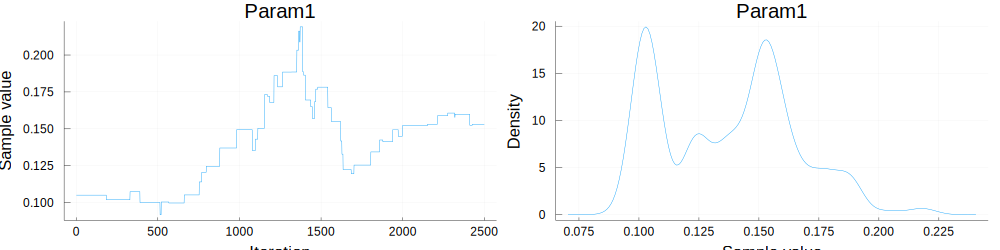

In [89]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat([ϕ_sam[i, :] for i in 1:K]...);
ϕ_chain = Chains(ϕ_pos_sam[(N_pre_burn + 1):N_sam, 1:K, 1]);
pϕ = plot(ϕ_chain)

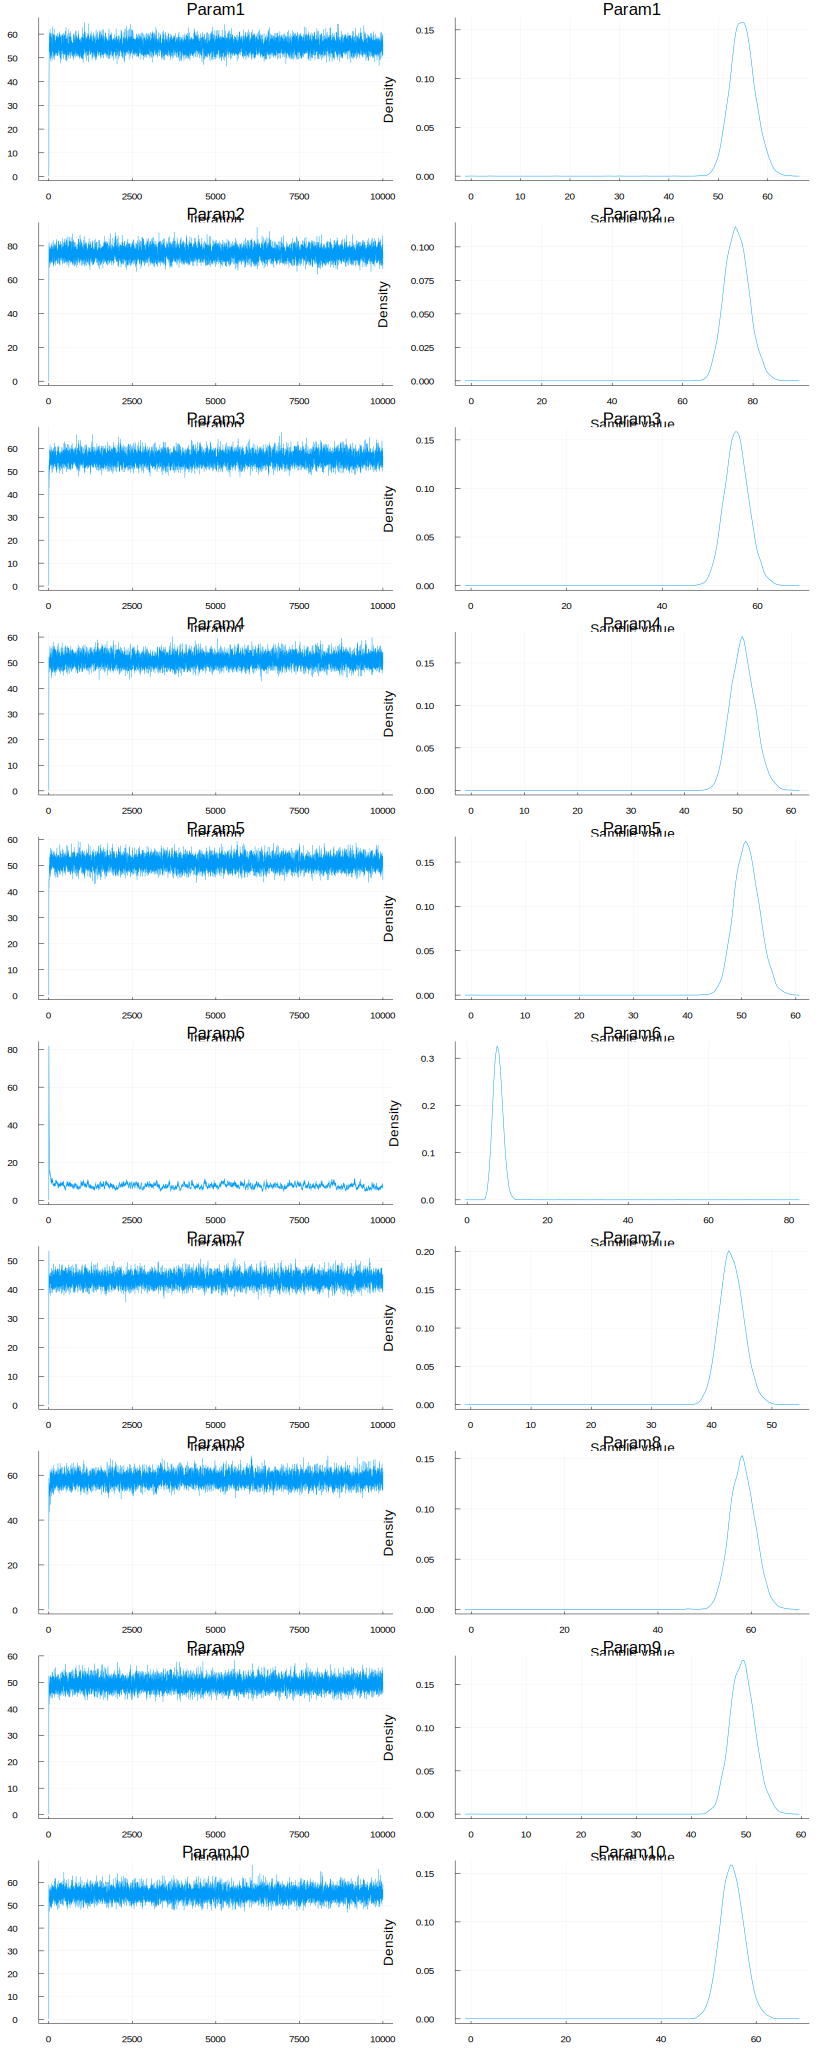

In [90]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q, 1);
Σ_pos_sam[:, :, 1] = hcat([Σ_sam[ind_Σ_sam .+ (ind - 1)] for ind in 1:q]...);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [49]:
sqrt_Σ_diag.^2

10-element Array{Float64,1}:
 0.5000000000000001 
 1.0                
 0.4                
 2.0000000000000004 
 0.29999999999999993
 2.5000000000000004 
 3.5                
 0.45               
 1.4999999999999998 
 0.5000000000000001 

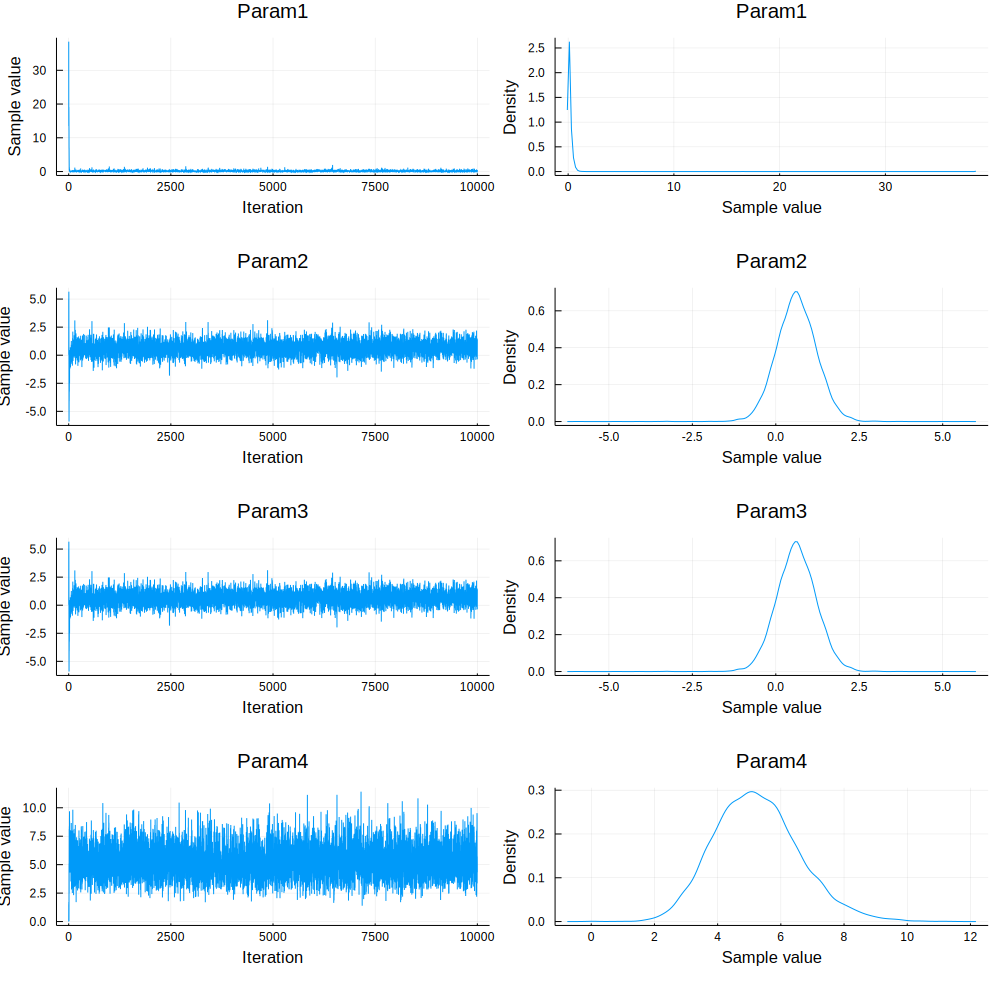

In [50]:
ω_cov_pos_sam = Array{Float64, 3}(undef, N_sam, 2 * 2, 1);
ω_cov_pos_sam[:, :, 1] = hcat(ω_cov_sam[ind_ω_cov_sam, 1], ω_cov_sam[ind_ω_cov_sam, 2], 
    ω_cov_sam[ind_ω_cov_sam .+ 1, 1], ω_cov_sam[ind_ω_cov_sam .+ 1, 2]);
ω_cov_chain = Chains(ω_cov_pos_sam);
pωcov = plot(ω_cov_chain)

In [51]:
covω = cov(ω_ord[S, :])

10×10 Array{Float64,2}:
  53.9708     16.2301    -13.2895   …    9.32631   6.4527     -0.852158
  16.2301     77.7575     -3.96849     -21.6502   -0.121156   -0.91495 
 -13.2895     -3.96849    61.0376       -9.94518   1.36396    17.4464  
  -0.241791   -5.71747    -8.13419      11.7421    5.78095     7.12631 
  16.792      -8.66271    -5.02395       1.41484  10.3854    -14.3496  
  -3.31036   -17.046     -18.9734   …   16.8315   15.7013    -13.9243  
   1.12033   -10.029       1.78648       7.47816   3.15576     1.10879 
   9.32631   -21.6502     -9.94518      63.9227   12.833     -12.0259  
   6.4527     -0.121156    1.36396      12.833    52.169      -7.59388 
  -0.852158   -0.91495    17.4464      -12.0259   -7.59388    58.4165  

In [52]:
corω = cor(ω_ord[S, :])

10×10 Array{Float64,2}:
  1.0          0.250536    -0.231542   …   0.158783    0.121606    -0.0151766
  0.250536     1.0         -0.0576043     -0.307088   -0.00190224  -0.0135756
 -0.231542    -0.0576043    1.0           -0.159216    0.0241711    0.292172 
 -0.00462945  -0.0912013   -0.146448       0.20658     0.11258      0.131149 
  0.320726    -0.137846    -0.0902311      0.0248307   0.201757    -0.263441 
 -0.0518344   -0.222368    -0.279363   …   0.242168    0.250064    -0.209569 
  0.0224267   -0.167257     0.0336276      0.137551    0.0642532    0.0213344
  0.158783    -0.307088    -0.159216       1.0         0.222226    -0.196799 
  0.121606    -0.00190224   0.0241711      0.222226    1.0         -0.137559 
 -0.0151766   -0.0135756    0.292172      -0.196799   -0.137559     1.0      

# Posterior Inference 

In [53]:
ω_cov_pos_sam_mean = [mean(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) 
    for i in 1:q, j in 1:q]

10×10 Array{Float64,2}:
  0.142971    0.641802    0.647561  …  -0.660049  -0.502839    0.546716
  0.641802    5.26068     5.24623      -5.36106   -4.0704      4.41908 
  0.647561    5.24623     5.38395      -5.43529   -4.12464     4.48173 
 -0.11367    -0.921559   -0.93562       0.95515    0.724079   -0.785437
 -0.336632   -2.7512     -2.78894       2.84807    2.16359    -2.35098 
 -2.35368   -18.9796    -19.2466    …  19.6509    14.9275    -16.2056  
 -0.757048   -6.12232    -6.20419       6.33606    4.81242    -5.22469 
 -0.660049   -5.36106    -5.43529       5.6174     4.21357    -4.57526 
 -0.502839   -4.0704     -4.12464       4.21357    3.25727    -3.47523 
  0.546716    4.41908     4.48173      -4.57526   -3.47523     3.8361  

In [54]:
ω_corr_sam = [(Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q]) * 
    ω_cov_sam[ind_ω_cov_sam[l] .+ (1:q) .- 1, 1:q] * 
        Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q])) for l in 1:N_sam];

In [55]:
ω_corr_sam_mean = [mean([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
    for j in 1:q, k in 1:q] 

10×10 Array{Float64,2}:
  1.0      0.7344   0.7344  -0.6728  …  -0.7344  -0.7344  -0.7344   0.7344
  0.7344   1.0      1.0     -0.9128     -1.0     -1.0     -1.0      1.0   
  0.7344   1.0      1.0     -0.9128     -1.0     -1.0     -1.0      1.0   
 -0.6728  -0.9128  -0.9128   1.0         0.9128   0.9128   0.9128  -0.9128
 -0.7344  -1.0     -1.0      0.9128      1.0      1.0      1.0     -1.0   
 -0.7344  -1.0     -1.0      0.9128  …   1.0      1.0      1.0     -1.0   
 -0.7344  -1.0     -1.0      0.9128      1.0      1.0      1.0     -1.0   
 -0.7344  -1.0     -1.0      0.9128      1.0      1.0      1.0     -1.0   
 -0.7344  -1.0     -1.0      0.9128      1.0      1.0      1.0     -1.0   
  0.7344   1.0      1.0     -0.9128     -1.0     -1.0     -1.0      1.0   

In [64]:
# check the plot of the data 
using RCall
@rput ω_corr_sam_mean
R"""
library(corrplot)
library(corrgram)

colnames(ω_corr_sam_mean) <- c(1:10)
rownames(ω_corr_sam_mean) <- c(1:10)

width <- 720
height <- 720
pointsize <- 16


png(paste("../../pics/sim3_factor_corr_K1_plot.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
#corrplot(ω_corr_sam_mean, method="number", type = "upper", diag = FALSE, 
#         addshade = "negative", number.digits = 2, tl.pos = "td")

corrgram(ω_corr_sam_mean, order=FALSE, lower.panel=panel.shade, gap = 0.2,
         upper.panel=panel.pie, text.panel=panel.txt, main=" ",
         col.regions = colorRampPalette(c( "darkseagreen3",
                                           "white", "cadetblue3")))
dev.off()
"""

┌ Warning: RCall.jl: corrplot 0.84 loaded
└ @ RCall /home/luzhang/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Registered S3 method overwritten by 'seriation':
│   method         from 
│   reorder.hclust gclus
└ @ RCall /home/luzhang/.julia/packages/RCall/g7dhB/src/io.jl:113


RObject{IntSxp}
null device 
          1 


In [65]:
# CVG-slope #
count_slope = 0.0
for i in 2:p
    for j in 1:q
        if ((quantile(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)], [0.025])[1] < 
                β[i, j] ) && (quantile(
                        γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)], [0.975])[1] > 
                β[i, j] ))
            count_slope = count_slope + 1.0;
        end
        
    end
end
count_slope

19.0

In [66]:
# CVL #
count_ω_incp = fill(0.0, q);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
            ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
    end
end
count_ω_incp;

In [67]:
print(round.(count_ω_incp ./ n, digits = 5))

[0.14583, 0.16167, 0.18583, 0.13333, 0.15667, 0.9075, 0.23083, 0.18, 0.17667, 0.17333]

In [68]:
sum(count_ω_incp) / (q*n)

0.24516666666666667

In [69]:
# CVG #
count_Y_M = fill(0.0, q);
Y_m_pos_qt = [Array{Float64, 2}(undef, length(M_ind[ind]), 3) for ind in 1:q];

for i in 1:q
    for j in 1:length(M_ind[i])
        count_Y_M[i] = count_Y_M[i] + (((Y_m_sam_mean[i][j] - 
                1.96 * sqrt(Y_m_sam_var[i][j])) < Y_ord[M_ind[i][j], i]) && 
         ((Y_m_sam_mean[i][j] + 1.96 * sqrt(Y_m_sam_var[i][j])) > 
                Y_ord[M_ind[i][j], i]))
    end
end
print(round.(count_Y_M ./ 200, digits = 4));
print(round.(mean(count_Y_M ./ 200), digits = 4))

[0.96, 0.975, 0.95, 0.94, 0.965, 0.965, 0.95, 0.95, 0.945, 0.945]0.9545

In [70]:
# RMSPE #
MSPE = (sum([sum((Y_m_sam_mean[i] - Y_ord[S[M_Sind[i]], i]).^2) for i in 1:q])) / 
    (sum([length(M_Sind[i]) for i in 1:q]))
RMSPE = sqrt(MSPE); 
print(round.([sqrt((sum((Y_m_sam_mean[i] - Y_ord[S[M_Sind[i]], i]).^2)) / 
        length(M_Sind[i])) for i in 1:q], digits = 4));
print(round(RMSPE, digits = 4));

[7.0479, 8.1784, 7.3885, 7.6711, 6.5891, 3.9213, 6.6981, 7.7799, 6.8291, 7.3855]7.0382

In [71]:
@save "../results/K1/Factor_mean_var_K1.jld" ω_incp_sam_mean ω_incp_sam_var Y_m_sam_mean Y_m_sam_var Y_ord S_ind M_Sind K p q N_sam N_pre_burn